In [1]:
# Import necessary libraries
import wandb
import pandas as pd
import matplotlib.pyplot as plt

# Login to wandb (if not already logged in)
wandb.login()

# Define the project and entity
project_name = "Negatives"
entity_name = "ntourne"

# Initialize the wandb API
api = wandb.Api()

# Fetch all runs from the project
runs = api.runs(f"{entity_name}/{project_name}")

wandb: Currently logged in as: ntourne to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [2]:
# Initialize a list to store results
results = []

# Iterate through runs and extract metrics
for run in runs:
    # Get the summary metrics, config, and name of the run
    summary = run.summary._json_dict
    config = run.config
    name = run.name
    
    # Combine the data into a single dictionary
    run_data = {
        "run_name": name,
        "TF": config.get("TF"),
        "celltype": config.get("celltype"),
        "neg_mode": config.get("neg_mode"),
        "cross_val_set": config.get("cross_val_set"),
        "group_name": config.get("group_name"),
        "AUROC": summary.get("best_AUROC"),
        "AUROC_HQ": summary.get("best_AUROC_HQ"),
        "Accuracy": summary.get("best_Accuracy"),
        "Accuracy_HQ": summary.get("best_Accuracy_HQ"),
        "val_loss": summary.get("val_loss"),
    }
    results.append(run_data)

# Convert the results into a DataFrame
results_df = pd.DataFrame(results)

In [3]:
results_df = results_df[results_df['group_name'] == "prelim_run_1"]

In [8]:
# Filter out entries where AUROC_HQ == 0
filtered_out_count = results_df[results_df['AUROC_HQ'] == 0].shape[0]

# Filter the DataFrame to exclude these entries
results_df = results_df[results_df['AUROC_HQ'] != 0]

# Print the count of filtered-out entries
print(f"Number of entries where AUROC_HQ == 0: {filtered_out_count}")

Number of entries where AUROC_HQ == 0: 14


In [9]:
results_df["TF"].value_counts()

TF
CTCF                 24
Max                  24
FOSL2                24
TCF12                24
ATF3                 24
BHLHE40              24
ZBTB33               24
SIX5                 24
USF-1                24
YY1_(SC-281)         18
CREB1_(SC-240)       18
ELF1_(SC-631)        18
ETS1                 16
FOXA1_(SC-101058)    12
Name: count, dtype: int64

/tmp/ipykernel_404255/2935107674.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df['TF-neg_mode'] = results_df['TF'] + '-' + results_df['neg_mode']


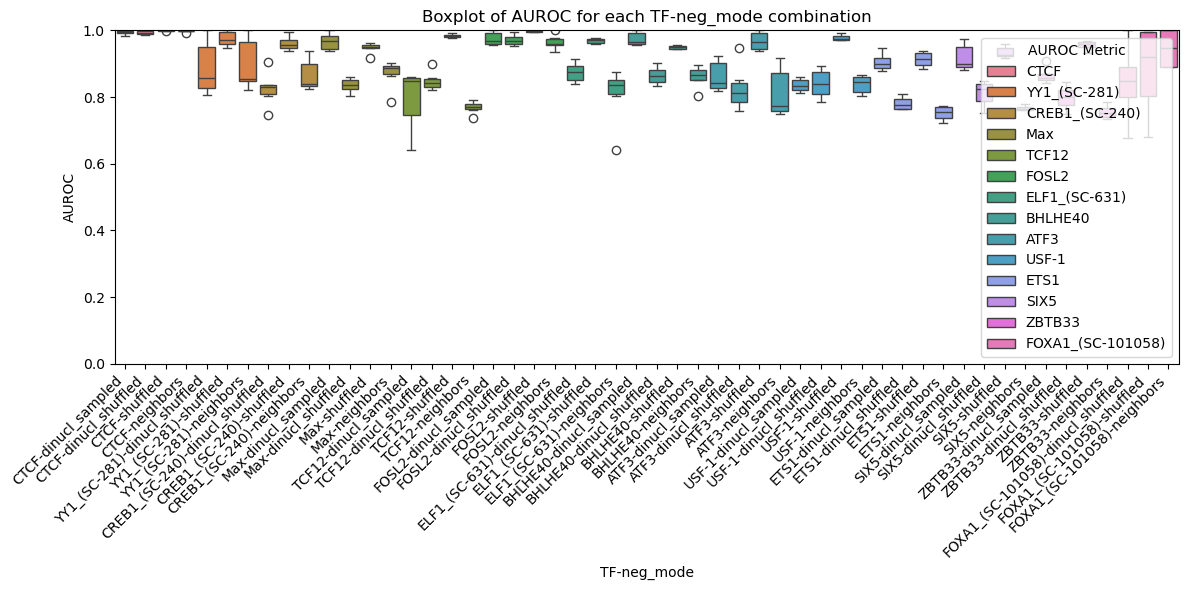

In [10]:
import seaborn as sns

# Create a new column combining TF and neg_mode
results_df['TF-neg_mode'] = results_df['TF'] + '-' + results_df['neg_mode']

# Create the boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=results_df, x='TF-neg_mode', y='AUROC', hue="TF")
plt.xticks(rotation=45, ha='right')
plt.title('Boxplot of AUROC for each TF-neg_mode combination')
plt.legend(title='AUROC Metric', loc='lower right')
plt.xlabel('TF-neg_mode')
plt.ylabel('AUROC')
plt.ylim(0,1)
plt.tight_layout()
plt.show()

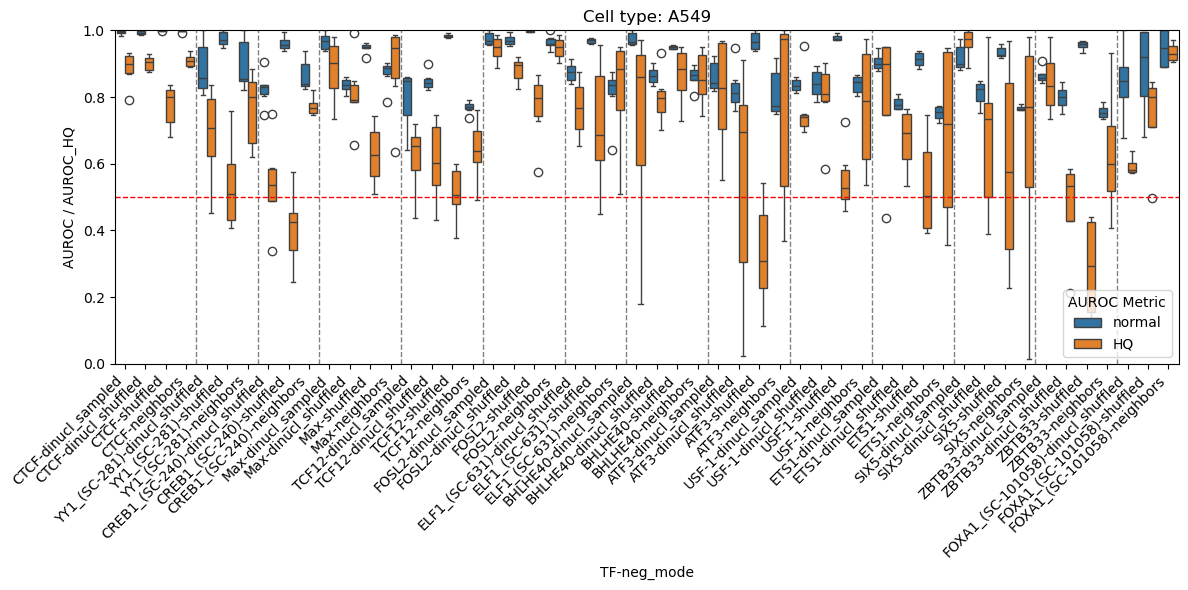

In [12]:
# Create the boxplot for AUROC
plt.figure(figsize=(12, 6))

# Create a new DataFrame with AUROC and AUROC_HQ combined into a single column
melted_df = pd.melt(
    results_df,
    id_vars=['TF-neg_mode'],
    value_vars=['AUROC', 'AUROC_HQ'],
    var_name='auroc_metric',
    value_name='AUROC_value'
)

# Map the metric names to more descriptive labels
melted_df['auroc_metric'] = melted_df['auroc_metric'].map({'AUROC': 'normal', 'AUROC_HQ': 'HQ'})

# Create the boxplot
sns.boxplot(data=melted_df, x='TF-neg_mode', y='AUROC_value', hue='auroc_metric')

# Add vertical lines between groups of the same TF
unique_tf_neg_modes = results_df['TF-neg_mode'].unique()
tf_groups = [tf.split('-')[0] for tf in unique_tf_neg_modes]
group_changes = [i for i in range(1, len(tf_groups)) if tf_groups[i] != tf_groups[i - 1]]

for change in group_changes:
    plt.axvline(change - 0.5, color='gray', linestyle='--', linewidth=1)

# Add a horizontal line at y=0.5
plt.axhline(y=0.5, color='red', linestyle='--', linewidth=1)

# Adjust legend
plt.legend(title='AUROC Metric', loc='lower right')

# Adjust plot aesthetics
plt.xticks(rotation=45, ha='right')
plt.title('Cell type: A549')
plt.xlabel('TF-neg_mode')
plt.ylabel('AUROC / AUROC_HQ')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

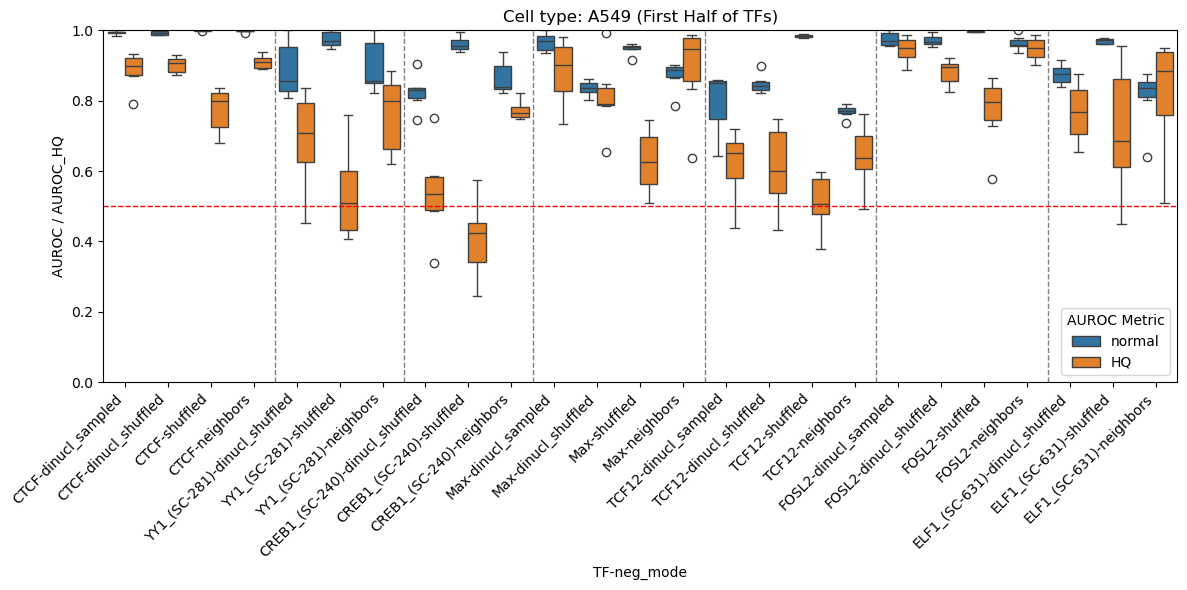

In [16]:
# Calculate the half index
half_index = len(unique_tf_neg_modes) // 2 -1

# Create the boxplot for AUROC (first half of TFs)
plt.figure(figsize=(12, 6))

# Filter the DataFrame to include only the first half of the TF-neg_mode values
half_tf_neg_modes = unique_tf_neg_modes[:half_index]
filtered_melted_df = melted_df[melted_df['TF-neg_mode'].isin(half_tf_neg_modes)]

# Create the boxplot
sns.boxplot(data=filtered_melted_df, x='TF-neg_mode', y='AUROC_value', hue='auroc_metric')

# Add vertical lines between groups of the same TF
tf_groups = [tf.split('-')[0] for tf in half_tf_neg_modes]
group_changes = [i for i in range(1, len(tf_groups)) if tf_groups[i] != tf_groups[i - 1]]

for change in group_changes:
    plt.axvline(change - 0.5, color='gray', linestyle='--', linewidth=1)

# Add a horizontal line at y=0.5
plt.axhline(y=0.5, color='red', linestyle='--', linewidth=1)

# Adjust legend
plt.legend(title='AUROC Metric', loc='lower right')

# Adjust plot aesthetics
plt.xticks(rotation=45, ha='right')
plt.title('Cell type: A549 (First Half of TFs)')
plt.xlabel('TF-neg_mode')
plt.ylabel('AUROC / AUROC_HQ')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


In [7]:
# Extract the order based on neg_mode
order = results_df.sort_values(by='neg_mode')['TF-neg_mode'].unique()

# Plot the difference
plt.figure(figsize=(12, 6))
sns.barplot(data=results_df, x='TF-neg_mode', y='AUROC_diff', hue='TF', order=order)

# Adjust plot aesthetics
plt.xticks(rotation=45, ha='right')
plt.title('Difference between AUROC and HQ AUROC for each TF-neg_mode combination')
plt.xlabel('TF-neg_mode')
plt.ylabel('AUROC - HQ AUROC')
plt.tight_layout()
plt.show()

ValueError: Could not interpret value `AUROC_diff` for `y`. An entry with this name does not appear in `data`.

<Figure size 1200x600 with 0 Axes>

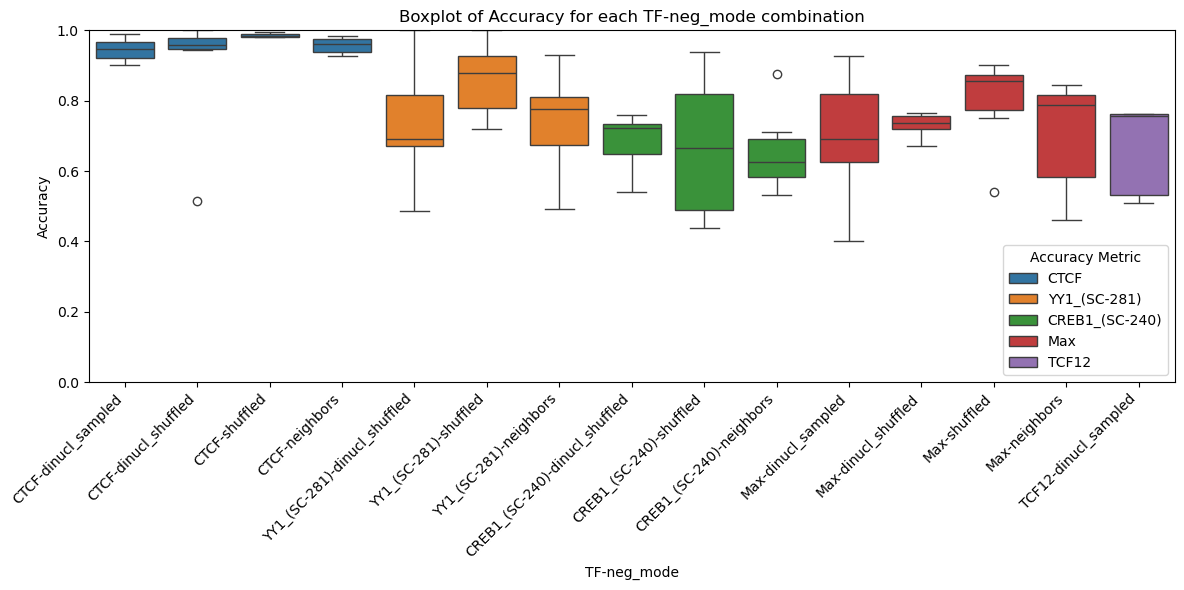

In [ ]:
# Create the boxplot for Accuracy
plt.figure(figsize=(12, 6))
sns.boxplot(data=results_df, x='TF-neg_mode', y='Accuracy', hue="TF")
plt.xticks(rotation=45, ha='right')
plt.title('Boxplot of Accuracy for each TF-neg_mode combination')
plt.legend(title='Accuracy Metric', loc='lower right')
plt.xlabel('TF-neg_mode')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


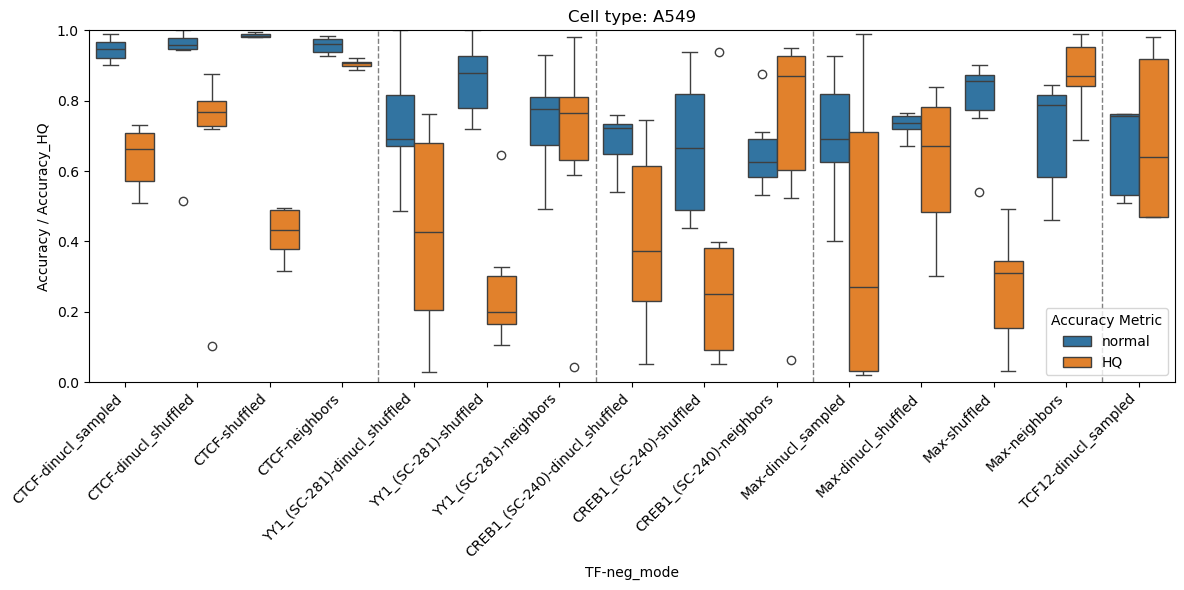

In [ ]:
# Create the boxplot for Accuracy
plt.figure(figsize=(12, 6))

# Create a new DataFrame with Accuracy and Accuracy_HQ combined into a single column
melted_df_accuracy = pd.melt(
    results_df,
    id_vars=['TF-neg_mode'],
    value_vars=['Accuracy', 'Accuracy_HQ'],
    var_name='accuracy_metric',
    value_name='Accuracy_value'
)

# Map the metric names to more descriptive labels
melted_df_accuracy['accuracy_metric'] = melted_df_accuracy['accuracy_metric'].map({'Accuracy': 'normal', 'Accuracy_HQ': 'HQ'})

# Create the boxplot
sns.boxplot(data=melted_df_accuracy, x='TF-neg_mode', y='Accuracy_value', hue='accuracy_metric')

# Add vertical lines between groups of the same TF
unique_tf_neg_modes = results_df['TF-neg_mode'].unique()
tf_groups = [tf.split('-')[0] for tf in unique_tf_neg_modes]
group_changes = [i for i in range(1, len(tf_groups)) if tf_groups[i] != tf_groups[i - 1]]

for change in group_changes:
    plt.axvline(change - 0.5, color='gray', linestyle='--', linewidth=1)

# Adjust legend
plt.legend(title='Accuracy Metric', loc='lower right')

# Adjust plot aesthetics
plt.xticks(rotation=45, ha='right')
plt.title('Cell type: A549')
plt.xlabel('TF-neg_mode')
plt.ylabel('Accuracy / Accuracy_HQ')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()